In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
## Imports...
# Math
from random import randint

# For deep learning algo
from keras import layers
from keras import models
from tensorflow.keras.utils import to_categorical

# For machine learning algo
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, VotingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier  


# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# **Import Data**
Let's import the data first and look at them.

In [3]:
train_data = pd.read_csv("../input/titanic/train.csv")

print("Train_data shape: ", train_data.shape, "\n")
print("Train data:")
train_data.head()

Train_data shape:  (891, 12) 

Train data:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_data = pd.read_csv("../input/titanic/test.csv")

print("Test_data shape:", test_data.shape, "\n")
print("Test data:")
test_data.head()

Test_data shape: (418, 11) 

Test data:


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Let's join the train and test datasets so we can reduce the nulber of operations.

In [5]:
joined_data = [train_data, test_data]

# 1. Exploraty Data Analysis
## 1.1. **Look at missing Data**
We can visualize the missing data with a heatmap from seaborn.

In [6]:
print("Columns with NaN values in train_data:")
train_data.columns[train_data.isna().any()].tolist()

Columns with NaN values in train_data:


['Age', 'Cabin', 'Embarked']

In [7]:
# Look at the percentage of missing values in the training data
train_data.isnull().mean()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

<AxesSubplot:>

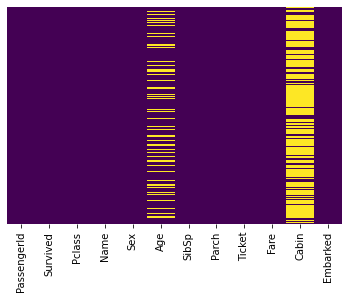

In [8]:
sns.heatmap(train_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [9]:
print("Columns with NaN values in train_data:")
test_data.columns[test_data.isna().any()].tolist()

Columns with NaN values in train_data:


['Age', 'Fare', 'Cabin']

In [10]:
# Look at the percentage of missing values in the test data
test_data.isnull().mean()

PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.205742
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.002392
Cabin          0.782297
Embarked       0.000000
dtype: float64

<AxesSubplot:>

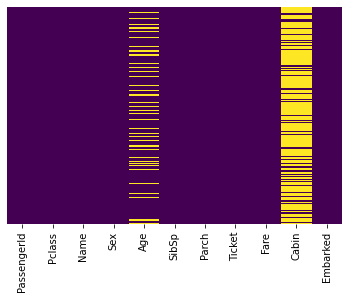

In [11]:
sns.heatmap(test_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Since more almost 78% of data is missing in the column 'Cabin' we will probably drop it or change it into another feature.
## 1.2. Helpers

In [12]:
# To plot on a barchart the survival rate per element in a set of a column
def get_survival_rates(dataset, column):
    # For q column return an array whose the 1st column are the categories of the column
    # And the second column contain the survival rate per category
    data = np.array(list(dataset.groupby([column]).Survived.mean().to_dict().items()))
    
    # Plot, and make sure that y data is float
    p = sns.barplot(x=data[:, 0], y=data[:, 1].astype(np.float))

    # Drawing  of the survival rate
    p.axhline(survival_rate)

    # Add legend
    p.set_xlabel(column, fontsize = 20)
    p.set_ylabel("Survival rate per {}".format(column), fontsize = 20)
    return p

## **1.3. Survival rate**
Number of passengers who survived / Total number of passengers

In [13]:
# Let's be curious and look first at the ratio dead / survived
survival_rate = sum(train_data.Survived) / len(train_data)
print("Ratio dead / survived: ", '{:.1%}'.format(survival_rate))

Ratio dead / survived:  38.4%


## **1.4. Test Patterns**
### **1.4.1. Test Pattern based on sex**
We can see huge a huge difference in the survival rate between men and women.

,Sex,Survived
0,female,0.742038
1,male,0.188908


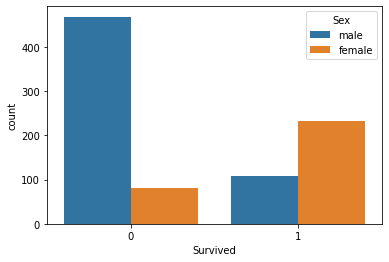

In [14]:
sns.countplot(x="Survived", hue="Sex", data=train_data)

train_data[["Sex", "Survived"]].groupby(["Sex"], as_index=False).mean()

In [15]:
# Let's submit data based on the pattern above: return 0 if he passenger is a male, 1 otherwise
predictions = test_data.Sex.replace(["male", "female"], [0, 1])

This will be give a score of 0.76555. This is our ground basis. Now Let's dive into the data a bit more
### **1.4.2. Test Pattern based on age categories**

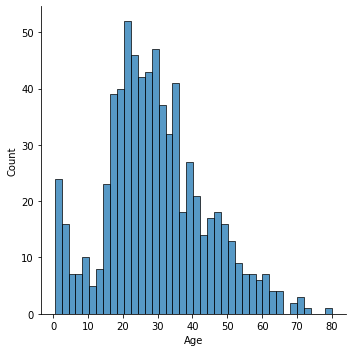

In [16]:
sns.displot(train_data['Age'].dropna(), kde=False, bins=40)

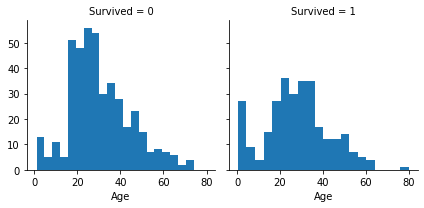

In [17]:
g = sns.FacetGrid(train_data, col='Survived')
g.map(plt.hist, 'Age', bins=20)

Just looking at the graph above, it does not seem that an age category is more prone to survive than another.  <br> 
<br>

### **1.4.3. Test Pattern based on sibsp**
Reminder: sibsp is the # of siblings / spouses aboard the Titanic.

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


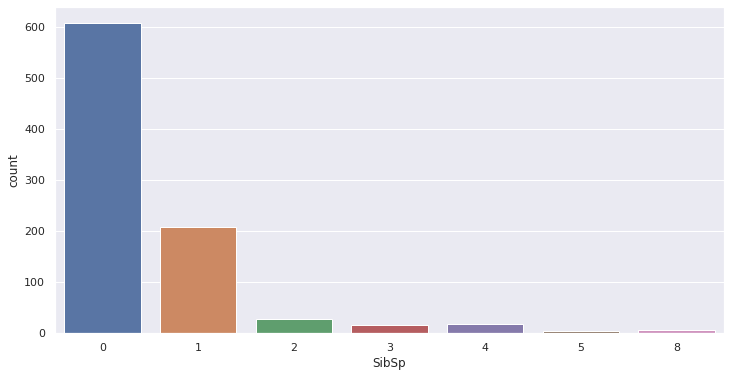

In [18]:
sns.set(rc = {'figure.figsize':(12,6)})
sns.countplot(x=train_data["SibSp"])

train_data[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

<AxesSubplot:xlabel='SibSp', ylabel='Survival rate per SibSp'>

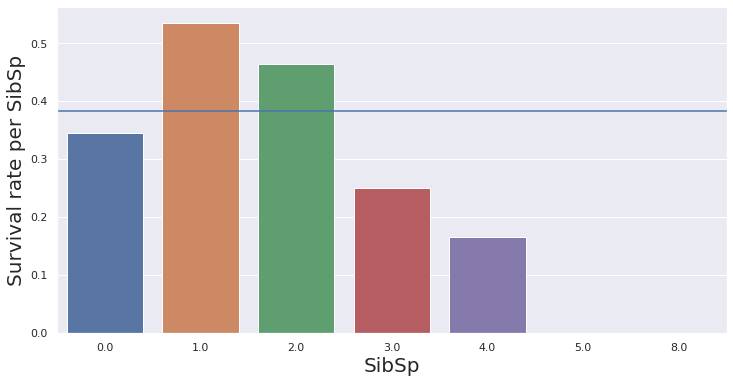

In [19]:
get_survival_rates(train_data, "SibSp")

We can see that none of the passengers with 5 or more siblings survive.
### **1.4.4. Test Patterns based on Sex and Sibsp**

In [20]:
# Table with survial rate per number of siblings, for women only
train_data[["SibSp", "Sex", "Survived"]][train_data.Sex == 'female'].groupby(['SibSp'], as_index=False).mean().head(10)

,SibSp,Survived
0,0,0.787356
1,1,0.754717
2,2,0.769231
3,3,0.363636
4,4,0.333333
5,5,0.000000
6,8,0.000000


We can see from this data that women with 3 or more siblings are much more likely to be dead (around twive more likely).

In [21]:
# Table with survial rate per number of siblings, for men only
train_data[["SibSp", "Sex", "Survived"]][train_data.Sex == 'male'].groupby(['SibSp'], as_index=False).mean().head(10)

,SibSp,Survived
0,0,0.168203
1,1,0.310680
2,2,0.200000
3,3,0.000000
4,4,0.083333
5,5,0.000000
6,8,0.000000


We can see from the data above that:
* All men with 3, 5 or 8 siblings are dead
* Men with 4 siblings are more that twive more likely to be dead
<br>

### **1.4.5. Test Pattern on Pclass**

<AxesSubplot:xlabel='Survived', ylabel='count'>

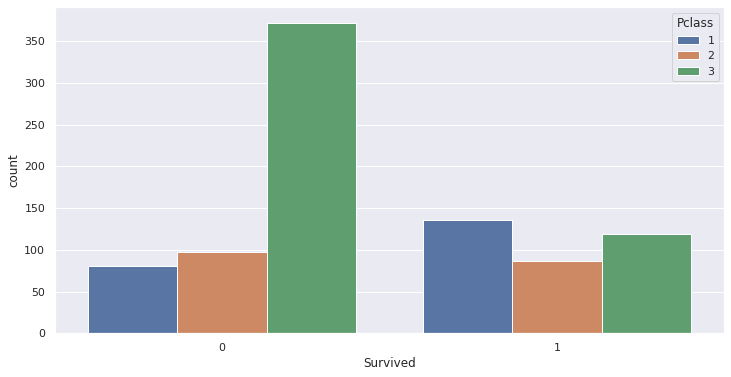

In [22]:
sns.countplot(x="Survived", hue="Pclass", data=train_data)

In [23]:
train_data[["Pclass", "Survived"]].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


Pclass 1 is almost 3 times more likely to survive than Pclass 3 !!

### **1.4.6. Test Pattern based on Embarked**

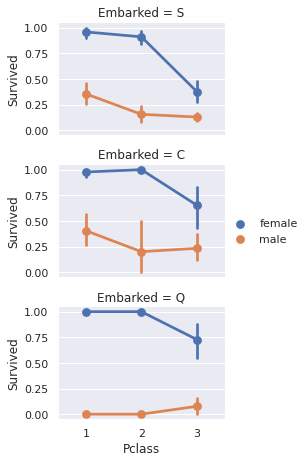

In [24]:
grid = sns.FacetGrid(train_data, row='Embarked', height=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep', order=[1,2,3], hue_order=["female","male"])
#grid.map(sns.pointplot(x='Pclass', y='Survived', hue='Sex', data=train_data, palette='deep'))
grid.add_legend()

### **1.4.8. Test Pattern on Fare**

<AxesSubplot:>

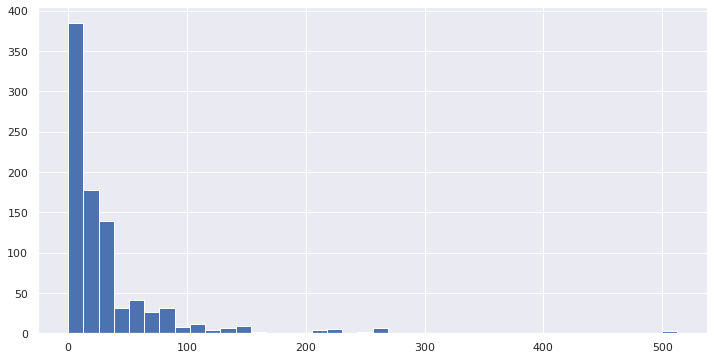

In [25]:
train_data['Fare'].hist(bins=40)

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


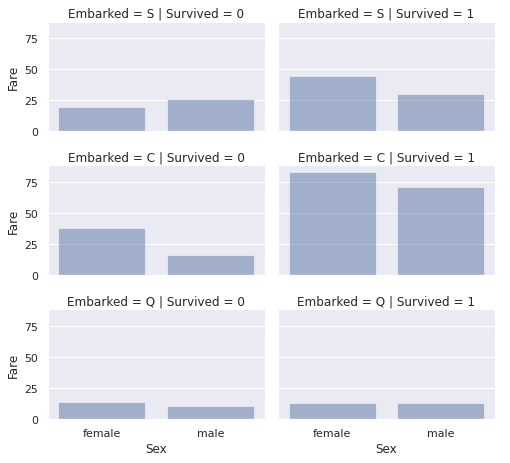

In [26]:
grid = sns.FacetGrid(train_data, row='Embarked', col='Survived', height=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

## **1.5. Data Cleaning**

In [27]:
# Reminder
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [28]:
# Reminder
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### 1.5.1. Dropping features
For now we drop the 'Cabin' and 'Ticket' column because too many data are missing for this feature. Let's also drop the feature 'Name'. We won't use it for the time being.

In [29]:
train_data.drop(['Cabin', 'Ticket', 'Name', "PassengerId"], axis=1, inplace=True)
test_data.drop(['Cabin', 'Ticket', 'Name'], axis=1, inplace=True)

train_data.dropna(inplace=True)
#test_data.dropna(inplace=True)

### 1.5.2 Age - Inference for missing values
We will assume that Age is missing completely at random (MCAR). A possible approach would be to replace the NaN values randomly from the given ages (**Random Sample Imputation**). However we can expect a correlation between the age and the Pclass. Let's look at that...

Mean age of Pclass 1 : 38.10554347826087
Mean age of Pclass 2 : 29.87763005780347
Mean age of Pclass 3 : 25.14061971830986


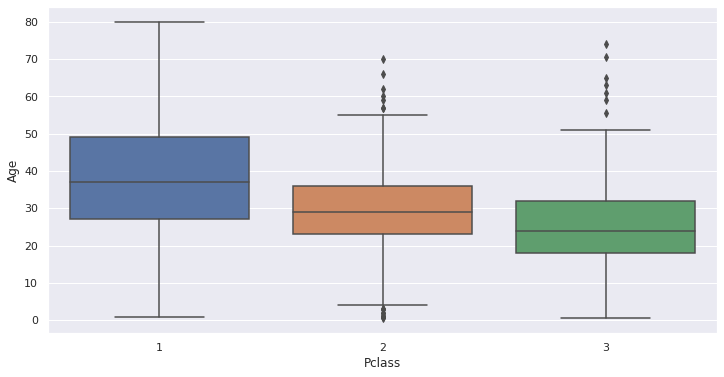

In [30]:
sns.boxplot(x='Pclass', y='Age', data=train_data)
mean_ages = dict() # mean age per Pclass
for i in set(train_data.Pclass):
    mean = np.mean(train_data[train_data.Pclass == i]['Age'].dropna())
    mean_ages[i] = mean
    print(('Mean age of Pclass {} : {}').format(i, mean))

Looking at the chart above, we can see that the age is also correlated with the Pclass. The avarage age to Pclass is higher than the one of Pclass 3. Thi can be expected (one can fairly assume that, in general,  an older person can afford more than a younger one). This, another imputation method could have been to calculate the average age per Pclass.

In [31]:
def impute_age(dataset):
    dataset["Age_imputed"] = dataset.Age
    random_sample=dataset.Age.dropna().sample(dataset.Age.isnull().sum(), random_state=0)
    random_sample.index=dataset[dataset.Age.isnull()].index
    dataset.loc[dataset.Age.isnull(), "Age_imputed"]=random_sample

In [32]:
impute_age(train_data)

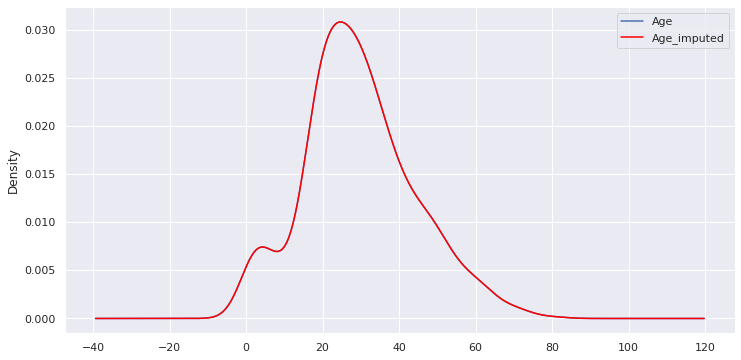

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
train_data.Age.plot(kind='kde', ax=ax)
train_data.Age_imputed.plot(kind='kde', ax=ax, color='red')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

Almost no change in the variance, very nice !

In [34]:
# Let's do the same for test_data
impute_age(test_data)
test_data.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_imputed
0,892,3,male,34.5,0,0,7.8292,Q,34.5
1,893,3,female,47.0,1,0,7.0000,S,47.0
2,894,2,male,62.0,0,0,9.6875,Q,62.0
3,895,3,male,27.0,0,0,8.6625,S,27.0
4,896,3,female,22.0,1,1,12.2875,S,22.0


In [35]:
train_data.drop('Age', axis=1, inplace=True)
test_data.drop('Age', axis=1, inplace=True)

### 1.5.3 Age - Convert to categorical values

In [36]:
train_data['Age_Range'] = pd.qcut(train_data['Age_imputed'], 5)
train_data[['Age_Range', 'Survived']].groupby(['Age_Range'], as_index=False).mean().sort_values(by='Age_Range', ascending=True)

,Age_Range,Survived
0,"(0.419, 19.0]",0.481707
1,"(19.0, 25.0]",0.328467
2,"(25.0, 31.0]",0.393701
3,"(31.0, 41.0]",0.433566
4,"(41.0, 80.0]",0.368794


Text(0, 0.5, 'Survival rate')

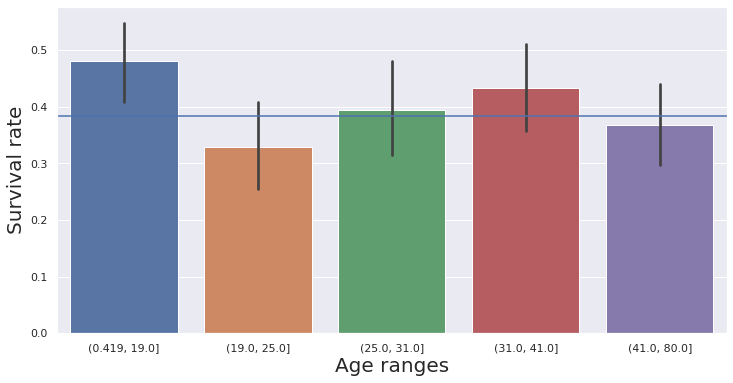

In [37]:
p = sns.barplot(x='Age_Range', y = 'Survived', data=train_data)
p.axhline(survival_rate)

# Add legend
p.set_xlabel("Age ranges", fontsize = 20)
p.set_ylabel("Survival rate", fontsize = 20)

In [38]:
for dataset in joined_data:
    dataset.loc[ dataset['Age_imputed'] <= 19, 'Age_imputed'] = 0
    dataset.loc[(dataset['Age_imputed'] > 19) & (dataset['Age_imputed'] <= 25), 'Age_imputed'] = 1
    dataset.loc[(dataset['Age_imputed'] > 25) & (dataset['Age_imputed'] <= 31), 'Age_imputed'] = 2
    dataset.loc[(dataset['Age_imputed'] > 31) & (dataset['Age_imputed'] <= 41), 'Age_imputed'] = 3
    dataset.loc[ dataset['Age_imputed'] > 41, 'Age_imputed'] = 4
    #dataset['Fare'] = dataset['Fare'].astype(int)

train_data['Age_imputed'] = train_data['Age_imputed'].astype(int)
test_data['Age_imputed'] = test_data['Age_imputed'].astype(int)

train_data = train_data.drop(['Age_Range'], axis=1)
joined_data = [train_data, test_data]
train_data.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Age_imputed
0,0,3,male,1,0,7.2500,S,1
1,1,1,female,1,0,71.2833,C,3
2,1,3,female,0,0,7.9250,S,2
3,1,1,female,1,0,53.1000,S,3
4,0,3,male,0,0,8.0500,S,3


### 1.5.4 Sex - Convertion to numerical values
Now we can replace the Sex value with a numerical values where 0 = female and 1 = male.

In [39]:
for dataset in joined_data:
    dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male':1}).astype(int)


train_data.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Age_imputed
0,0,3,1,1,0,7.2500,S,1
1,1,1,0,1,0,71.2833,C,3
2,1,3,0,0,0,7.9250,S,2
3,1,1,0,1,0,53.1000,S,3
4,0,3,1,0,0,8.0500,S,3


### 1.5.5. Fare
The test_data is missing a value in teh  Fare feature. Let's replace it by the median to be less sensitive to the outliers.

In [40]:
test_data.Fare.replace(np.nan, test_data.Fare.median(), inplace=True)

In [41]:
train_data['FareBand'] = pd.qcut(train_data['Fare'], 4)
train_data[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 8.05]",0.204188
1,"(8.05, 15.646]",0.321212
2,"(15.646, 33.0]",0.486034
3,"(33.0, 512.329]",0.615819


In [42]:
for dataset in joined_data:
    dataset.loc[ dataset['Fare'] <= 8.05, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 8.05) & (dataset['Fare'] <= 15.646), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 15.646) & (dataset['Fare'] <= 33), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > 33, 'Fare'] = 3
    #dataset['Fare'] = dataset['Fare'].astype(int)

train_data['Fare'] = train_data['Fare'].astype(int)
test_data['Fare'] = test_data['Fare'].astype(int)

train_data = train_data.drop(['FareBand'], axis=1)
joined_data = [train_data, test_data]
train_data.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Age_imputed
0,0,3,1,1,0,0,S,1
1,1,1,0,1,0,3,C,3
2,1,3,0,0,0,0,S,2
3,1,1,0,1,0,3,S,3
4,0,3,1,0,0,0,S,3


### 1.5.6. Embarked
Let's just replace the missing embarked feature by the most recurrent category. Only 2 values are missing in the train_data (and not in the test_data).

In [43]:
train_data.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Age_imputed
0,0,3,1,1,0,0,S,1
1,1,1,0,1,0,3,C,3
2,1,3,0,0,0,0,S,2
3,1,1,0,1,0,3,S,3
4,0,3,1,0,0,0,S,3


In [44]:
train_data.Embarked.replace(np.nan, train_data.Embarked.mode()[0], inplace=True)

Like we did for the Sex feature let's convert the Embarked feature to numerical values where S=0, C=1 and Q=2.

In [45]:
for dataset in joined_data:
    dataset['Embarked'] = dataset['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)
    
train_data.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Age_imputed
0,0,3,1,1,0,0,0,1
1,1,1,0,1,0,3,1,3
2,1,3,0,0,0,0,0,2
3,1,1,0,1,0,3,0,3
4,0,3,1,0,0,0,0,3


# **2. Models**
## 2.1. Based on Patterns
Let's assmue the following:
1. All women with "Ptclass <= 2" survived
3. 50% of the remaning women died (randomly)
4. 50% men with "Ptclass = 1" and "SibSp >= 1" survives (randomly)
5. 15% of remaning men died (randomly)

In [46]:
# rate the survival rate
import random
def random_survive(rate):
    if random.random() >= (1 - rate):
        return 1
    else:
        return 0

In [47]:
pattern_model = test_data.copy()

pattern_model["Survived"] = list([0]*len(test_data.index))

# 1 - All women with "Ptclass <= 2" survived
pattern_model['Survived'] = np.where((pattern_model.Sex == 0) & (pattern_model.Pclass <= 2), 1, pattern_model.Survived)
# 2 - 50% of the remaning women died (randomly)
pattern_model['Survived'] = np.where((pattern_model.Sex == 0) & (pattern_model.Pclass > 2), random_survive(0.7), pattern_model.Survived)
# 3 - 50% men with "Ptclass = 1" and "SibSp >= 1" survives (randomly)
pattern_model['Survived'] = np.where((pattern_model.Sex == 1) & (pattern_model.Pclass == 1), random_survive(0.5), pattern_model.Survived)
# 4 - 15% of remaning men died (randomly)
pattern_model['Survived'] = np.where((pattern_model.Sex == 1) & (pattern_model.Pclass != 1), random_survive(0.15), pattern_model.Survived)

pattern_model.head()

,PassengerId,Pclass,Sex,SibSp,Parch,Fare,Embarked,Age_imputed,Survived
0,892,3,1,0,0,0,2,3,0
1,893,3,0,1,0,0,0,4,1
2,894,2,1,0,0,1,2,4,0
3,895,3,1,0,0,1,0,2,0
4,896,3,0,1,1,1,0,1,1


In [48]:
pattern_model.Survived.mean()

0.5

## 2.2. Logistic Regression Model

In [49]:
X_train = train_data.drop(['Survived'], axis = 1)
y_train = train_data.Survived

X_test = test_data.drop(['PassengerId'], axis = 1)

In [50]:
logmodel = LogisticRegression(solver='liblinear')
logmodel.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [51]:
logmodel_score = cross_val_score(logmodel, X_train, y_train, cv = 10, scoring = 'accuracy').mean()
print("Logistic Regression score: ", logmodel_score)
acc_log = round(logmodel.score(X_train, y_train) * 100, 2)
print(acc_log)

Logistic Regression score:  0.7837636932707356
79.63


In [52]:
log_pred = logmodel.predict(X_test)

In [53]:
coeff_df = pd.DataFrame(train_data.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logmodel.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
4,Fare,0.384230
5,Embarked,0.162637
3,Parch,-0.117106
6,Age_imputed,-0.228803
2,SibSp,-0.373193
0,Pclass,-0.661535
1,Sex,-2.346606


## 2.3. Random Forest Classifier

In [54]:
rf = RandomForestClassifier(n_estimators=110, max_depth= 8, max_features='auto',
                                    random_state=0, oob_score=False, min_samples_split = 2,
                                    criterion= 'gini', min_samples_leaf=2, bootstrap=False)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=8, min_samples_leaf=2,
                       n_estimators=110, random_state=0)

In [55]:
rf_score = cross_val_score(rf, X_train, y_train, cv = 10, scoring = 'accuracy').mean()
print("Random Forest Classifier score: ", rf_score)
acc_rf = round(rf.score(X_train, y_train) * 100, 2)
print(acc_rf)

Random Forest Classifier score:  0.8007824726134585
87.22


In [56]:
rf_pred = rf.predict(X_test)

## 2.4. KNN

In [57]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [58]:
knn_score = cross_val_score(knn, X_train, y_train, cv = 10, scoring = 'accuracy').mean()
print("KNN score: ", knn_score)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)
print(acc_knn)

KNN score:  0.7571400625978092
83.99


In [59]:
knn_pred = knn.predict(X_test)

## 2.5. Support Vector Machine

In [60]:
svc = LinearSVC(dual=False)
svc.fit(X_train, y_train)

LinearSVC(dual=False)

In [61]:
svc_score = cross_val_score(svc, X_train, y_train, cv = 10, scoring = 'accuracy').mean()
print("Support Vector Machine score: ", svc_score)
acc_svc = round(svc.score(X_train, y_train) * 100, 2)
print(acc_svc)

Support Vector Machine score:  0.7823356807511738
78.93


In [62]:
svc_pred = svc.predict(X_test)

## 2.6. Gradient Boosting Classifier

In [63]:
grdb_clf = GradientBoostingClassifier(max_depth = 4, max_features = 5, n_estimators=101 ,random_state=0)
grdb_clf.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=4, max_features=5, n_estimators=101,
                           random_state=0)

In [64]:
grdb_clf_score = cross_val_score(grdb_clf, X_train, y_train, cv = 10, scoring = 'accuracy').mean()
print("Gradient Boosting Classifier score: ", grdb_clf_score)
acc_grdb = round(grdb_clf.score(X_train, y_train) * 100, 2)
print(acc_grdb)

Gradient Boosting Classifier score:  0.8063967136150236
87.08


In [65]:
grdb_pred = grdb_clf.predict(X_test)

### Model Prediction Comparison

In [66]:
np.mean(rf_pred == grdb_pred)

0.9473684210526315

In [67]:
np.mean(log_pred == rf_pred)

0.8181818181818182

In [68]:
np.mean(grdb_pred == knn_pred)

0.8899521531100478

In [69]:
np.mean(knn_pred == svc_pred)

0.777511961722488

# 3. Submission

In [70]:
from scipy import stats

In [71]:
pred = stats.mode(np.concatenate((np.array([rf_pred]).T, 
                                  np.array([grdb_pred]).T,
                                  np.array([knn_pred]).T), axis=1).tolist(), axis=1)[0]

In [72]:
#output = pd.DataFrame({'PassengerId': pattern_model.PassengerId, 'Survived': pred.T[0]})
output = pd.DataFrame({'PassengerId': pattern_model.PassengerId, 'Survived': grdb_pred})
output.to_csv('submission.csv', index=False)
print("The submission was successfully saved!")

The submission was successfully saved!
